### Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The data set used in this contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

### Project Pipeline
* Data Reading/Data Understanding: Defining the path for train and test images 
* Dataset Creation: Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.
* Dataset visualisation: Create a code to visualize one instance of all the nine classes present in the dataset 

* Model Building & training: 
  - Create base CNN model:
    - No dropouts used
    - Over-fitting was observed
  - Model 2: With dropouts
    - Adding dropout layer helped to control over-fitting
    - Accuracy wa low now, arond ~65%
    - Class imbalance was observed
  - Model 3: using Data Augmentation
    - Augmentor library was used, to reduce class imbalance
    - Added one more layer of 128 to increase accuracy further

### Importing Skin Cancer Data

### Importing all the important libraries

In [66]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from glob import glob

import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
path_to_train_directory = "./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
path_to_test_directory = "./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list,
# these correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

#### Code to visualize one instance of all the nine classes present in the dataset

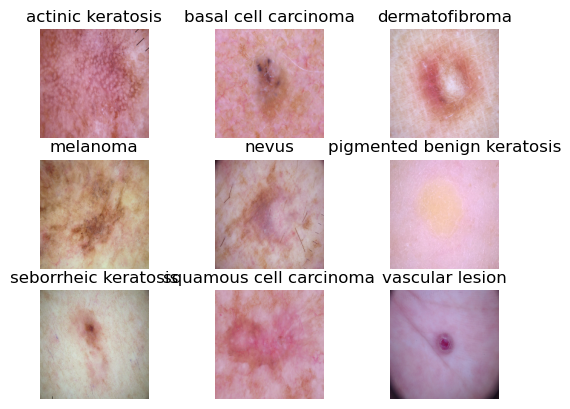

In [11]:
import matplotlib.pyplot as plt

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Create base CNN model, some of the important layers are following:

* Recaling: To normalize pixel values between (0,1)
* Convolution
* MaxPooling
* Flatten
* Dense

In [28]:
num_class = 9
model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class, activation='softmax')
])

### Compile the model

To compile model, folllwing options are taken:
* Optimiser: Adam
* Loss function: sparse_categorical_crossentropy 

In [29]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

### Train the model

Fit/Train the base model with 20 epocs

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 512ms/step - loss: 1.9750 - accuracy: 0.2500 - val_loss: 1.9642 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 26s 468ms/step - loss: 1.6686 - accuracy: 0.4169 - val_loss: 1.5514 - val_accuracy: 0.5056
Epoch 3/20
56/56 [==============================] - 16s 277ms/step - loss: 1.4333 - accuracy: 0.5190 - val_loss: 1.4657 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 15s 266ms/step - loss: 1.3493 - accuracy: 0.5368 - val_loss: 1.3980 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 14s 258ms/step - loss: 1.2170 - accuracy: 0.5681 - val_loss: 1.3519 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 14s 258ms/step - loss: 1.1637 - accuracy: 0.5871 - val_loss: 1.2946 - val_accuracy: 0.5593
Epoch 7/20
56/56 [==============================] - 14s 256ms/step - loss: 1.0697 - accuracy: 0.6205 - val_loss: 1.3470 - val_accuracy: 0.5235

### Visualizing training results

In [64]:
def visualize_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

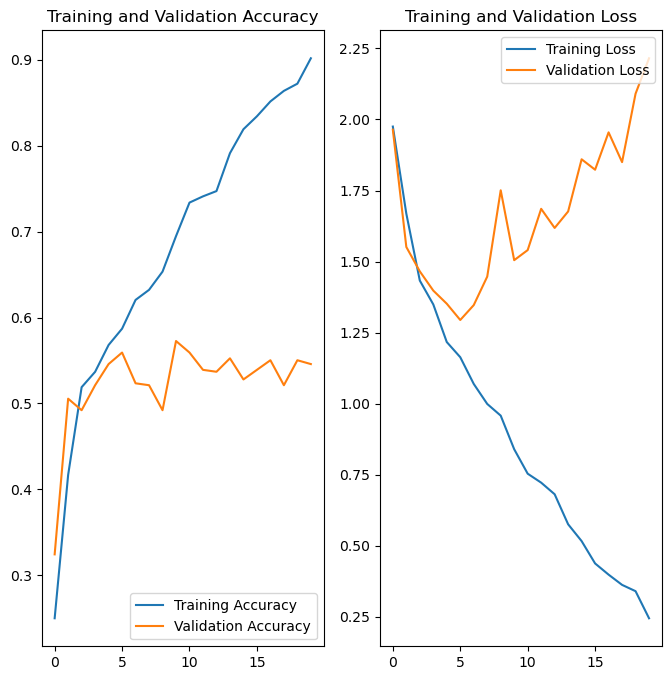

In [32]:
visualize_results(history)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

### Model final readings:
    * loss: 0.2452
    * accuracy: 0.9018
    * val_loss: 2.2153
    * val_accuracy: 0.5459
    
Validation accuracy is very low compared to training accuracy, which is clear sign of over-fittings.
We need to add "dropouts" to over-come over-fitting.

In [34]:
# Adding data augumentation strategy to handle underfit or overfit.
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

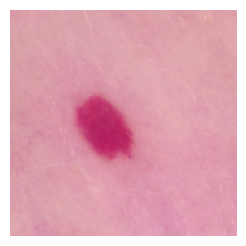

In [37]:
# Visualize augmentation strategy for one instance of training image.
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for index in range(len(class_names)):
        aug_img = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(aug_img[1].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

### Create the model 2:
* Adding new data augmentation layer
* Adding dropouts
* Compile Model
* Train the model


In [42]:
num_class = 9
model_2 = Sequential([
    data_augmentation,
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class, activation='softmax')
])

### Compiling the model

In [45]:
 model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [48]:
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 369ms/step - loss: 1.5663 - accuracy: 0.4425 - val_loss: 1.5641 - val_accuracy: 0.4519
Epoch 2/20
56/56 [==============================] - 21s 367ms/step - loss: 1.4561 - accuracy: 0.4855 - val_loss: 1.4617 - val_accuracy: 0.4899
Epoch 3/20
56/56 [==============================] - 20s 364ms/step - loss: 1.4643 - accuracy: 0.4782 - val_loss: 1.4623 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 20s 363ms/step - loss: 1.4128 - accuracy: 0.4955 - val_loss: 1.5053 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 20s 363ms/step - loss: 1.3423 - accuracy: 0.5385 - val_loss: 1.3836 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 20s 363ms/step - loss: 1.2897 - accuracy: 0.5419 - val_loss: 1.3675 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 20s 363ms/step - loss: 1.2657 - accuracy: 0.5502 - val_loss: 1.3279 - val_accuracy: 0.5235

### Visualizing the results

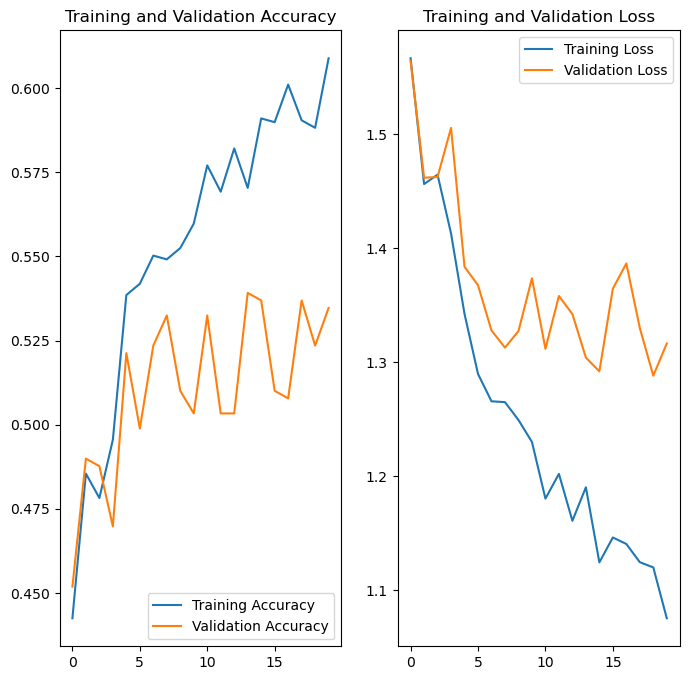

In [49]:
visualize_results(history)

### Model final readings:
    * loss: 1.0756
    * accuracy: 0.6088
    * val_loss: 1.3164
    * val_accuracy: 0.5347
    
With dropouts, over-fittings is handled but still accuracy is very low. Need to check class distribution.

#### Dropouts layer has helped to control overfitting, but accuracy of the mode is low.

Lets find distribution of classes in the training dataset, so if we have any class imbalance or not.

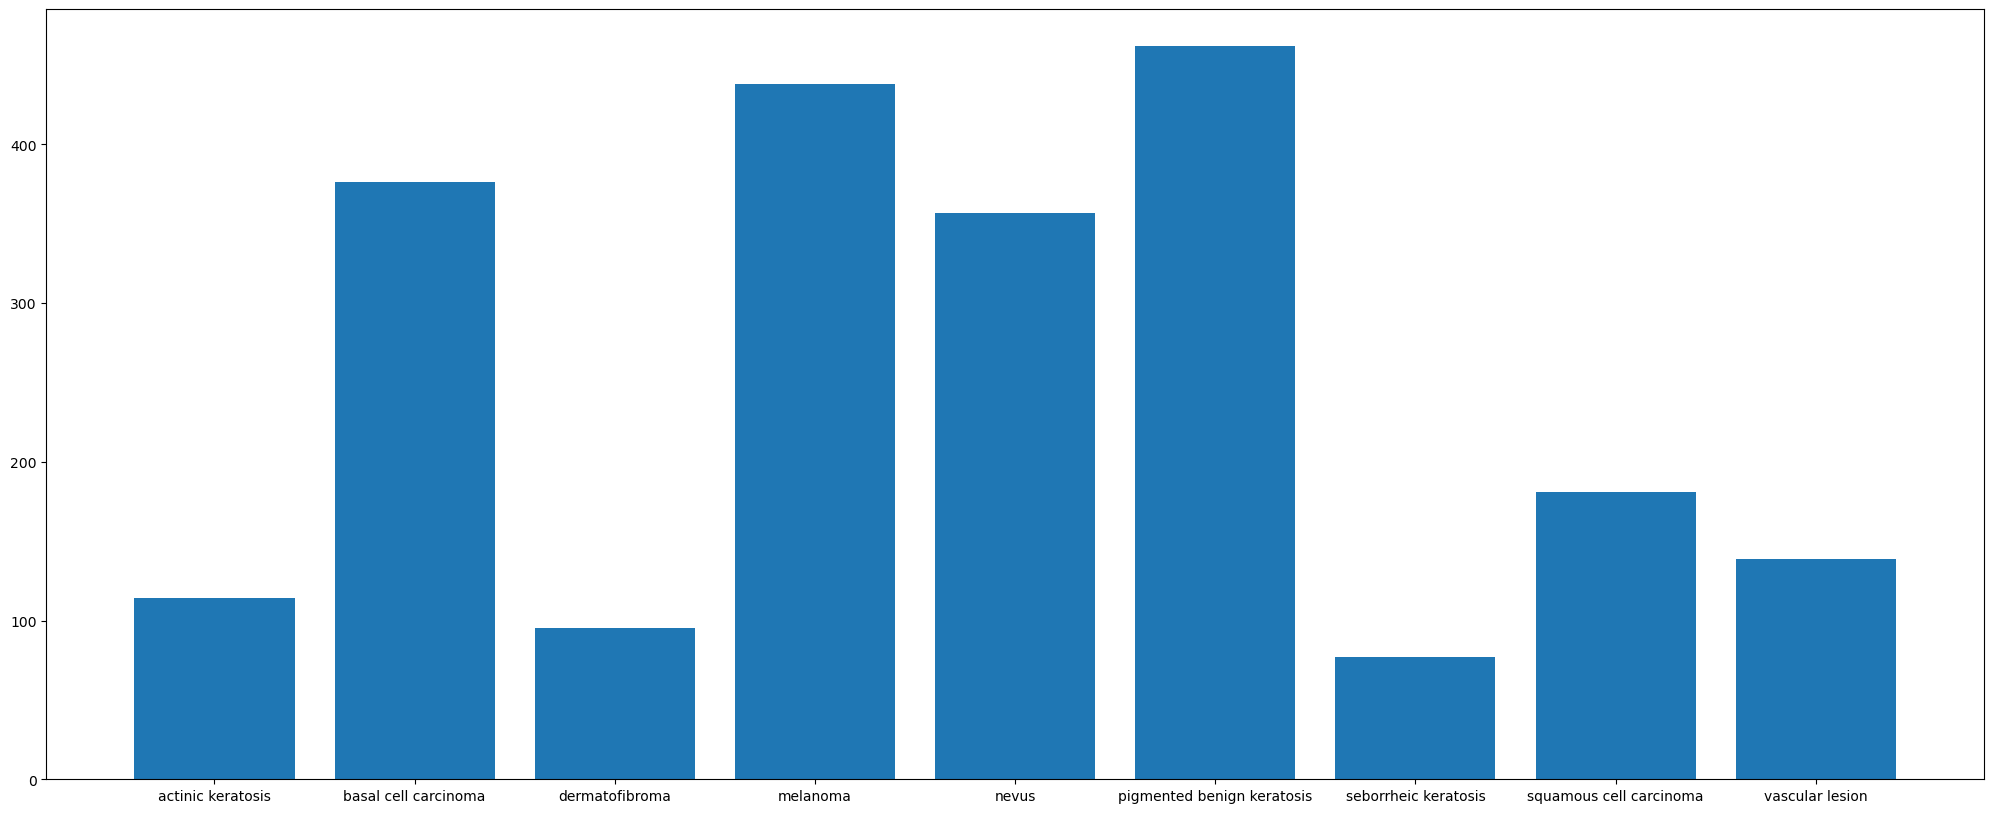

In [63]:
path_to_train_directory_1 = "./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
data_dir_train_1 = pathlib.Path(path_to_train_directory)

count=[]
for i in class_names:
    count.append(len(list(data_dir_train_1.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)
plt.show()

#### We surely have, class imbalance and hence need to rectify class imbalance.

### Classes with Least number of samples:
* seborrheic keratosis
* dermatofibroma

### Classes with Max samples:
* pigmented benign keratosis
* melanoma

In [32]:
path_list=[]
lesion_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
1,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
2,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
3,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
4,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
...,...,...
2234,CNN_assignment\Skin cancer ISIC The Internatio...,vascular lesion
2235,CNN_assignment\Skin cancer ISIC The Internatio...,vascular lesion
2236,CNN_assignment\Skin cancer ISIC The Internatio...,vascular lesion
2237,CNN_assignment\Skin cancer ISIC The Internatio...,vascular lesion


#### use Augmentor library for correct class imbalance.

In [ ]:
!pip install Augmentor

In [21]:
path_to_training_dataset="./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A9DCDB3D48>: 100%|█| 500/500 [00:03<00:00, 133.33 Samples


Initialised with 376 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A9DC937D88>: 100%|█| 500/500 [00:03<00:00, 137.82 Samples


Initialised with 95 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A9DCD87188>: 100%|█| 500/500 [00:03<00:00, 135.94 Samples


Initialised with 438 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=966x638 at 0x1A9DC8BA748>: 100%|█| 500/500 [00:15<00:00, 32.15 Samples/


Initialised with 357 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A9E045F308>: 100%|█| 500/500 [00:13<00:00, 37.47 Samples/


Initialised with 462 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A9DC937D08>: 100%|█| 500/500 [00:02<00:00, 180.27 Samples


Initialised with 77 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1A9D17362C8>: 100%|█| 500/500 [00:06<00:00, 82.71 Samples


Initialised with 181 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A9E046EE48>: 100%|█| 500/500 [00:02<00:00, 180.95 Samples


Initialised with 139 image(s) found.
Output directory set to ./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1A9DCCC6F88>: 100%|█| 500/500 [00:02<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [22]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9dbdcb8a-840f-49c6-a884-ea2ca6a447e6.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_0624d865-1869-40be-aac1-8c79a951c2ba.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_2209466b-6837-4df0-92a3-87e64f14cf79.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_4fdd851f-bf6e-4251-9634-46fdf4a06fa1.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_676c3b9b-de82-4e49-8ca0-e261c905b

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

###  Generate new Model using Augmented Data

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [52]:
data_dir_train="D:/Work/Course/upGrad/gitWork/MelanomaAssignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [53]:
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model
As we are using Augmented data now, so no need to have Augmented layer

In [54]:
num_class = 9
model_new = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.Dropout(0.25),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128,3,padding='same',activation= 'relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class, activation='softmax')
])

#### Compile your model

In [55]:
## your code goes here
model_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train your model

In [57]:
## Your code goes here, use 50 epochs.
epochs = 25
history = model_new.fit(
  train_ds_new,
  validation_data=val_ds_new,
  epochs=epochs
)

Epoch 1/25
169/169 [==============================] - 61s 359ms/step - loss: 0.2454 - accuracy: 0.9050 - val_loss: 0.5579 - val_accuracy: 0.8278
Epoch 2/25
169/169 [==============================] - 61s 360ms/step - loss: 0.2464 - accuracy: 0.8987 - val_loss: 0.5392 - val_accuracy: 0.8456
Epoch 3/25
169/169 [==============================] - 61s 357ms/step - loss: 0.2242 - accuracy: 0.9125 - val_loss: 0.5904 - val_accuracy: 0.8218
Epoch 4/25
169/169 [==============================] - 60s 353ms/step - loss: 0.2214 - accuracy: 0.9071 - val_loss: 0.5642 - val_accuracy: 0.8344
Epoch 5/25
169/169 [==============================] - 59s 350ms/step - loss: 0.2031 - accuracy: 0.9156 - val_loss: 0.6386 - val_accuracy: 0.8285
Epoch 6/25
169/169 [==============================] - 60s 351ms/step - loss: 0.1903 - accuracy: 0.9260 - val_loss: 0.5617 - val_accuracy: 0.8300
Epoch 7/25
169/169 [==============================] - 60s 352ms/step - loss: 0.1731 - accuracy: 0.9295 - val_loss: 0.5565 - val_ac

#### Visualize the model results

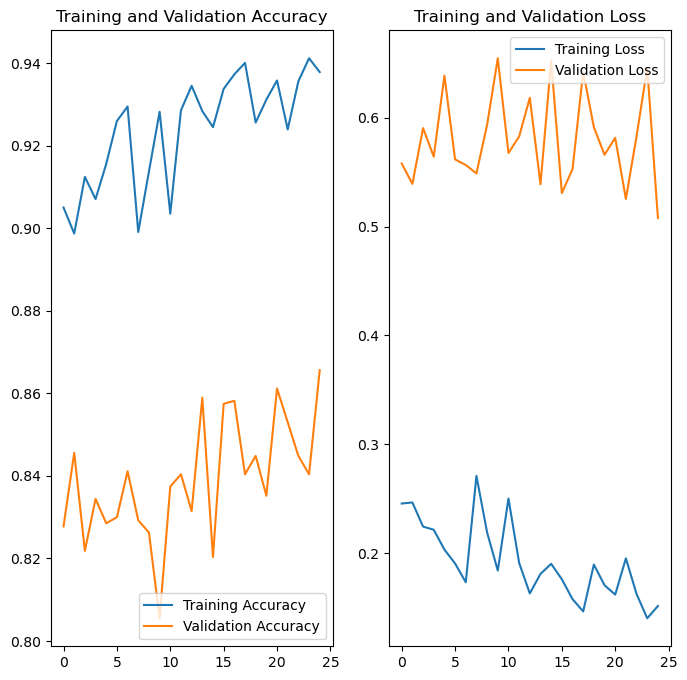

In [65]:
visualize_results(history)

### final Model readings:
    * loss: 0.1513
    * accuracy: 0.9379
    * val_loss: 0.5078
    * val_accuracy: 0.8656
    
Overall model is improved and accurary and validation accuracy of model has improved, following are the factors which has helped to imporve model:
* Dropout layer: Helped to get rid of over-fitting
* class Rebalance: This helped to increase the model accuracy
* Adding extra layer of 128: That has helped to increase the accuracy beyond 85%